# Practical 4 - Seismic attribute analysis

This notebook aims to build on your investigation of 3D seismic volumes from practical 3 by providing methods which we can use to enhance the identification of certain geological/environmental features. This is achieved through seismic attributes, attributes use some mathematical calculation of the data to enhance features, very similar to image processing techniques. 

**Learning Objectives**:

1)	Understand that modern seismic data analysis involves calculating seismic attributes to reveal features more clearly
2)	Understand that new attributes can be designed or multiple attributes combined to improve imaging
3)	Give you an appreciation that modern seismic data analysis will require the development of more sophisticated data analysis techniques


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import segyio
import scipy.ndimage
import pandas as pd
from mayavi import mlab

In [2]:
EXPLORE = False  # if False, the mayavi 3D images will not render.
EXPLORE

False

### 4.1 Explore a new 3D seismic data volume

We are going to start this exercise by loading a new 3D seismic data volume- Thebe_rift_faults. As we discussed in  lecture 6 this dataset comes from offshore NW Australia and shows some great examples of faults. This seismic datsets has time as the z-axis (ie it has not been depth converted yet).

In [3]:
base_segy = '../data/Thebe_rift_faults'
f = segyio.open(base_segy, ignore_geometry= True) #opens files like python default open call , assumes a well-structured 3D volume, 

In [4]:
print (segyio.tools.wrap(f.text[0])) #show text header to understand file better

C 1 SEGY OUTPUT FROM Petrel 2017.1 Thursday, November 18 2021 12:34:36
C 2 Name: FullStack_06-34degree Realized 1 Crop 2 Type: 3D seismic          C 3
C 4 First inline: 1753   Last inline: 2245
C 5 First xline:  2190   Last xline:  3063
C 6 CRS: Undefined
C 7 X min: 715563.75 max: 731309.44 delta: 15745.69
C 8 Y min: 7855437.24 max: 7871648.81 delta: 16211.58
C 9 Time min: -3193.50 max: -2383.50 delta: 810.00
C10 Lat min: - max: - delta: -
C11 Long min: - max: - delta: -
C12 Trace min: -3192.00 max: -2385.00 delta: 807.00
C13 Seismic (template) min: -9375.49 max: 12558.00 delta: 21933.49
C14 Amplitude (data) min: -9375.49 max: 12558.00 delta: 21933.49
C15 Trace sample format: IEEE floating point
C16 Coordinate scale factor: 100.00000
C17
C18 Binary header locations:
C19 Sample interval             : bytes 17-18
C20 Number of samples per trace : bytes 21-22
C21 Trace date format           : bytes 25-26
C22
C23 Trace header locations:
C24 Inline number               : bytes 5-8
C25 Xline

In [5]:
data = segyio.tools.cube(base_segy) #extremely easy for well structured data

In [6]:
def explore3d(data_cube):
    """
    visualise data volume
    """
    source = mlab.pipeline.scalar_field(data_cube)
    source.spacing = [1, 1, -1]
    vm = np.percentile(data_cube, 95) #may need to play a little with the 95

    nx, ny, nz = data_cube.shape
    mlab.pipeline.image_plane_widget(source, plane_orientation='x_axes', 
                                     slice_index=nx//2, colormap='coolwarm', vmin=-vm, vmax=vm)
    mlab.pipeline.image_plane_widget(source, plane_orientation='y_axes', 
                                     slice_index=ny//2, colormap='coolwarm', vmin=-vm, vmax=vm)
    mlab.pipeline.image_plane_widget(source, plane_orientation='z_axes', 
                                     slice_index=nz//2, colormap='coolwarm', vmin=-vm, vmax=vm)
    mlab.show()

In [7]:
if EXPLORE:
    explore3d(data)

**Ex 1: Spend some time looking through this data volume like you did in Exercise 3. Do you identify any interesting features that you recognise from the lecture 5 notes? If so, show some examples below:**

In the next part of the exercise you are going to use seismic attributes to try and highlight these geolgical features even further...

## 4.1.1. Attribute 1 - RMS amplitude

Amplitude attributes can be extracted along mapped horizons or from time/depth windows. RMS amplitude is just one example of an amplitude attribute. In this exercise we are going to calculate RMS between a time window. This involves squaring the amplitudes within the window and summing them, then square rooting. 

https://wiki.seg.org/wiki/RMS_amplitude

In [8]:
# C 4 First inline: 1753   Last inline: 2245
# C 5 First xline:  2190   Last xline:  3063

In [9]:
delta_inline = 2245 - 1753
delta_xline = 3063 - 2190

delta_inline, delta_xline

(492, 873)

In [10]:
# dims of data are: (inline, xline, depth)
data.shape

(493, 874, 270)

In [11]:
def rms(data):
    """
    Root mean square.
    
    Example
    >>> rms([3, 4, 5])
    4.08248290463863
    """
    return np.sqrt(np.sum(data**2) / data.size)

In [12]:
# np.convole is a like a moving average 

"""
For an 1D array: [a1, a2, a3, a4, ..... an]

if we apply a 1x3 kernel of 1s [1, 1, 1] and do np.convolve(arr, kernel, mode='same')

we get the following:

result = [a1+a2, a1+a2+a3, a2+a3+a4, ...]
"""
input = np.array([1, 2, 3, 4, 5, 6])
res = np.convolve(input, np.ones(3), 'same')

# for this, we are going to get the following:

# [(1+2), (1+2+3), (2+3+4), (3+4+5), (4+5+6) , (5+6)]
# [3, 6, 9, 12, 15, 11]

print(res)

assert np.allclose(res, np.array([(1+2), (1+2+3), (2+3+4), (3+4+5), (4+5+6) , (5+6)]))

# COMMENTs:
# - RMS is an attribute that is being applied here in 1D on the depth axis. 

[ 3.  6.  9. 12. 15. 11.]


In [13]:
def calculate_rms_attribute(data: np.array):
    """"""
    RMS = np.zeros(data.shape)
    RMS_kernel_size = 3
    for i in range(data.shape[0]):  # loop through inline
        for j in range(data.shape[1]):  # loop through xline
            # look at vertical depth slice inline, xline 
            trace = data[i,j,:]
            kernel = np.ones(RMS_kernel_size) / RMS_kernel_size  # range over which we take the RMS value (equation is root(square(n) / n))
            RMS_amp = np.sqrt(np.convolve(trace**2, kernel, 'same'))
            RMS[i,j,:] = RMS_amp

    return RMS

In [14]:
rms = calculate_rms_attribute(data)
rms.shape

(493, 874, 270)

In [15]:
if EXPLORE:
    explore3d(rms)

## 4.1.2. Attribute 2 - 1st vertical derivative in time

Any calculation you do with seismic data is a seismic attribute! New seismic attributes are invented all the time. You could invent your own! Some are really useful, and some less so... In this part of the exercise we will calcualte an attribute which is often found in seismic interpretation software- the 1st vertical derivative. This will highlight vertical gradients. Do you find this attribute highlights features any differently?

https://primer-computational-mathematics.github.io/book/d_geosciences/remote_sensing/Image_Filtering.html

In [16]:
t_max = -2383.50
t_min = -3193.50

t_rng = t_max - t_min
t_rng


depth_dim = data.shape[-1]

dt = t_rng / depth_dim
dt

3.0

In [17]:
def calculate_1st_derivate_attribute(data: np.array, dt: float):
    """"""
    dydx = np.zeros(data.shape)
    for i in range(data.shape[0]):  # loop through inline
        for j in range(data.shape[1]):  # loop through xline
            # look at vertical depth slice inline, xline 
            trace = data[i,j,:]
            # kernel = np.array([-1, 1])/dt  #forward difference --> https://en.wikipedia.org/wiki/Finite_difference
            kernel = np.array([1, -1]) / dt  # forward difference
            diff = np.convolve(trace, kernel, 'same')
            dydx[i,j,:] = diff

    return dydx

In [18]:
dydx = calculate_1st_derivate_attribute(data=data, dt=dt)
print(dydx.shape)

(493, 874, 270)


In [19]:
if EXPLORE:
    explore3d(dydx)

Please note the effect that our vm parameter has here when optimising our dynamic range! If you use the same dynamic range for both the effects become a lot clearer!

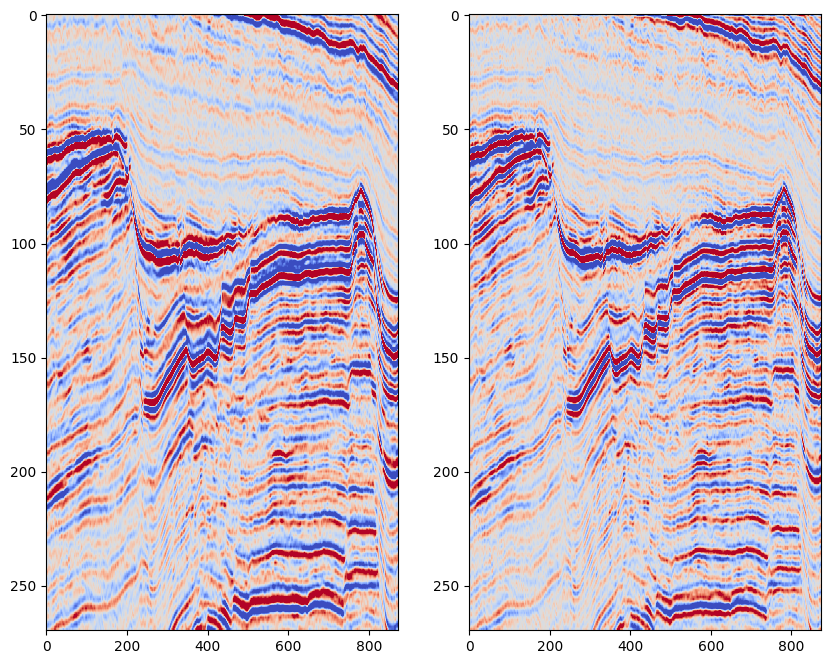

In [20]:
fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(121)
vm = np.percentile(data, 95)
ax1.imshow(data[0,:,:].T, cmap='coolwarm', aspect='auto', vmin=-vm, vmax=vm)
ax2 = plt.subplot(122)
vm = np.percentile(dydx, 95)
ax2.imshow(dydx[0,:,:].T, cmap='coolwarm', aspect='auto', vmin=-vm, vmax=vm)
plt.show()

## 4.1.3.  Attribute 3 - 2nd vertical derivative in time

...again, we can do any calculation we like with the data to design a new attribute. Do you find this one very helpful? Do any features become sharper/clearer?

In [21]:
def calculate_2nd_derivate_attribute(data: np.array, dt: float):
    """"""
    d2ydx2 = np.zeros(data.shape)
    for i in range(data.shape[0]):  # loop through inline
        for j in range(data.shape[1]):  # loop through xline
            # look at vertical depth slice inline, xline 
            trace = data[i,j,:]
            kernel = np.array([1, -2, 1]) / dt**2  # forward difference
            diff = np.convolve(trace, kernel, 'same')
            d2ydx2[i,j,:] = diff

    return d2ydx2

In [22]:
d2ydx2 = calculate_2nd_derivate_attribute(data=data, dt=dt)
print(d2ydx2.shape)

(493, 874, 270)


In [23]:
if EXPLORE:
    explore3d(d2ydx2)

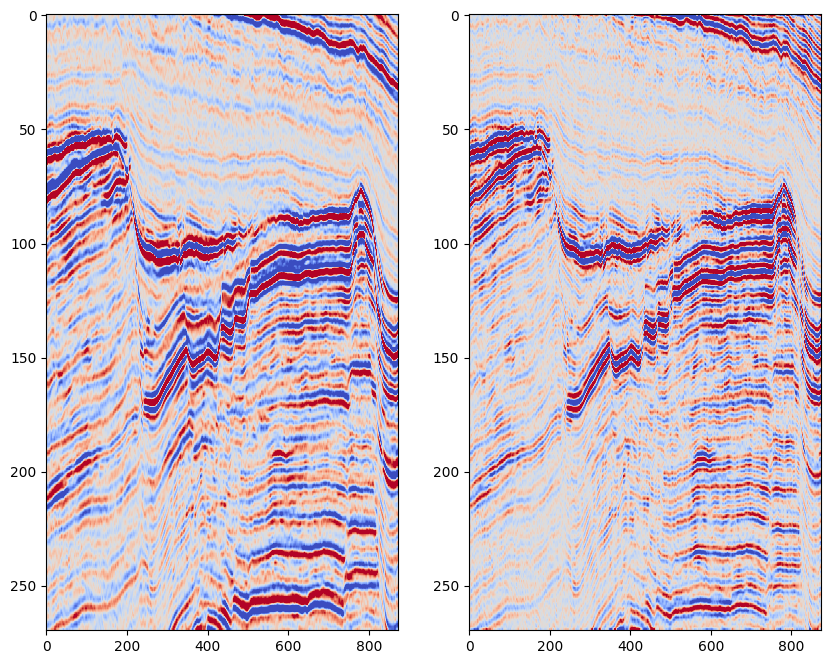

In [24]:
fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(121)
vm = np.percentile(data, 95)
ax1.imshow(data[0,:,:].T, cmap='coolwarm', aspect='auto', vmin=-vm, vmax=vm)
ax2 = plt.subplot(122)
vm = np.percentile(d2ydx2, 95)
ax2.imshow(d2ydx2[0,:,:].T, cmap='coolwarm', aspect='auto', vmin=-vm, vmax=vm)
plt.show()

## 4.1.4.  Atrribute 4- Coherency

As we discussed in lecture 6, discontinuity attributes are really important, and the algorithms to compute them are often trade-secrets in seismic interpretation software. In this part of the exercise we are using some code from a Github tutorial which shows a number of ways to calculate discontinuity attributes- https://github.com/seg/tutorials-2015/blob/master/1512_Semblance_coherence_and_discontinuity/writeup.md

In this exercise we are going to use the "marfurt semblance". Semblance (also known as coherence) is a measure of how similar seismic traces are to each other. This code is slow... so we are only going to calculate coherence for a few time slices. 


In [25]:
from typing import Callable

In [26]:
def moving_window(data: np.array, window: tuple, func: Callable):
    # `generic_filter` will give the function 1D input. We'll reshape it for convinence
    wrapped = lambda region: func(region.reshape(window))
    
    # The boundaries will be handled by "reflecting" the data, by default
    return scipy.ndimage.generic_filter(input=data,
                                        function=wrapped,
                                        footprint=np.ones(window),
                                        mode='reflect',
                                        )
def marfurt_semblance(region):
    # We'll need an ntraces by nsamples array
    # This stacks all traces within the x-y "footprint" into one
    # two-dimensional array.
    region = region.reshape(-1, region.shape[-1])
    ntraces, _ = region.shape
    square_of_sums = np.sum(region, axis=0)**2
    sum_of_squares = np.sum(region**2, axis=0)
    sembl = square_of_sums.sum() / sum_of_squares.sum()

    return sembl / ntraces

Due to the processing cost of coherency we will only be running this on 15 time-slices. You can run this for more layers if you like, but it may take a while. An applied eaxmple is shown below.

In [27]:
# due to processing cost we only run this on 15 layers
marfurt = moving_window(data=data[:,:,100:115], window=(3, 3, 9), func=marfurt_semblance)

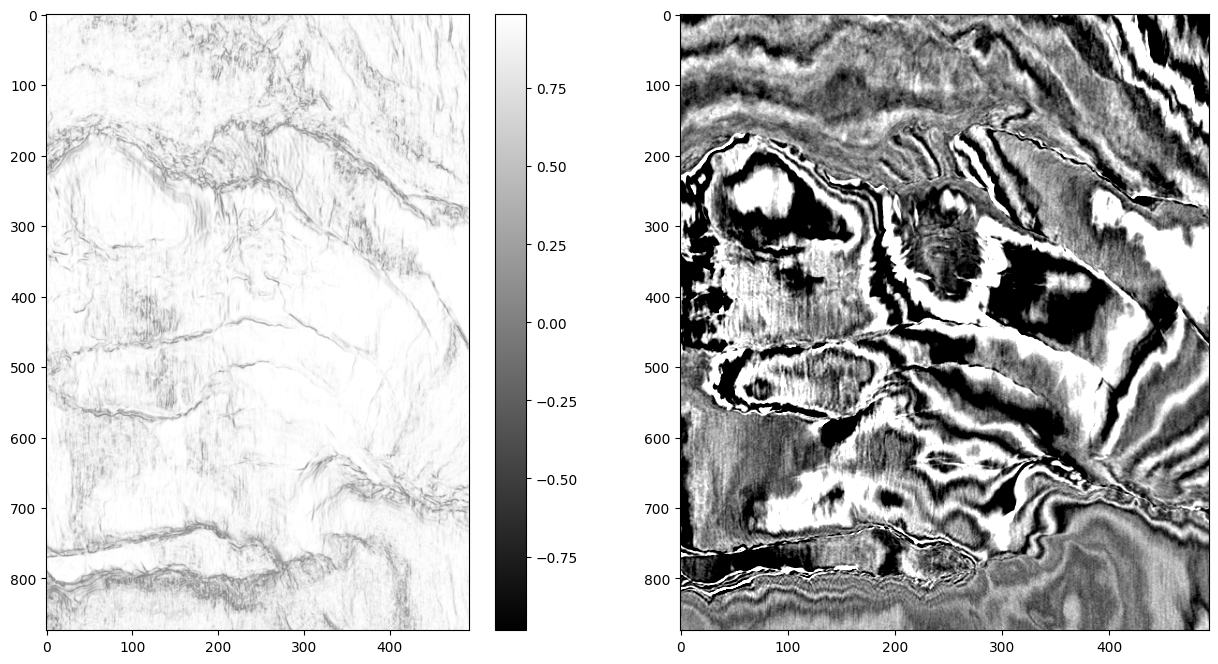

In [28]:
fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot(121)
vm = np.percentile(marfurt, 95)
plt.imshow(marfurt[:,:,0].T, cmap='gray', aspect='auto', vmin=-vm, vmax=vm)
plt.colorbar()
ax2 = plt.subplot(122)
vm = np.percentile(data, 95)
plt.imshow(data[:,:,101].T, cmap='gray', aspect='auto', vmin=-vm, vmax=vm)
plt.show()

**Ex 2: Does coherency help better highlight the features you observed in 4.1.1? If you were a seismic interpreter would you rather interpret these fetures in the amplitude time slices (ie time slices through the original seismic) or the coherence?**

<summary>💡 Answer</summary>

The figure above left shows the coherency attribute and the black areas are regions of high discontinuty. Faults cause discontinuites between reflections so we expect faults to be black in the above image. The black lines that you can see in the image above are faults, and the coherency attribute has revealed their geometry really clearly (without us having to do any manual interpretation). The figure in the top right is a horizontal slide through the original seismic data. You can just about see some offsets between the black and white fringes, which are faults, but it is much more difficult to get any idea about the geometry from this.

**Ex 3 (optional): You could go a step further and take the derivative of the coherency volume above... remember, any calculation you do is a seismic attribute! You never know... you might design the next big seismic attribute!**

##### Trying to figure out how scipy.ndimage.generic_filter() builds the window...

In [29]:
import numpy as np
from scipy import ndimage

def my_func(values):
   print(values, len(values))
   return sum(values) / len(values)

# Create a 2D array (image)
# image = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
# image = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]]])

# Create a sample 2D array (image)
image = np.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]]).reshape(3, 3, 1)

# Define the footprint
footprint = np.ones((3, 3, 1))

# # Apply the generic_filter function
# result = ndimage.generic_filter(input=image, 
#                                 function=my_func,
#                                 footprint=footprint,
#                                 mode='constant',
#                                 cval=-1,
#                                 origin=0)
result = ndimage.generic_filter(input=image,
                                function=my_func,
                                size=(3, 3, 1),
                              #   footprint=np.ones((3, 3, 1))
                                mode='reflect',
                                # cval=-1,
                                origin=0)

print('\n', footprint)
print(image, '\n')
print(result)

[1. 1. 2. 1. 1. 2. 4. 4. 5.] 9
[1. 2. 3. 1. 2. 3. 4. 5. 6.] 9
[2. 3. 3. 2. 3. 3. 5. 6. 6.] 9
[1. 1. 2. 4. 4. 5. 7. 7. 8.] 9
[1. 2. 3. 4. 5. 6. 7. 8. 9.] 9
[2. 3. 3. 5. 6. 6. 8. 9. 9.] 9
[4. 4. 5. 7. 7. 8. 7. 7. 8.] 9
[4. 5. 6. 7. 8. 9. 7. 8. 9.] 9
[5. 6. 6. 8. 9. 9. 8. 9. 9.] 9

 [[[1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]]]
[[[1]
  [2]
  [3]]

 [[4]
  [5]
  [6]]

 [[7]
  [8]
  [9]]] 

[[[2]
  [3]
  [3]]

 [[4]
  [5]
  [5]]

 [[6]
  [7]
  [7]]]


## 4.2. Attribute blending

It can be useful to overlay two or more attributes using transparency to highlight features even further- this is called multi-attribute analysis. Let's first visualise two different attributes side by side to understand visually what is ocurring with some of these attributes and which features they are enhancing

In [30]:
def explore3d_2(data_cube1, data_cube2, cmap1 = 'gray', cmap2 = 'gray'):
    """
    code to visualise two data volumes together
    """
    # https://github.com/seg/tutorials-2015/blob/master/1512_Semblance_coherence_and_discontinuity/Discontinuity_tutorial.ipynb
    source1 = mlab.pipeline.scalar_field(data_cube1)
    source1.spacing = [1, 1, -1]
    
    source2 = mlab.pipeline.scalar_field(data_cube2)
    source2.spacing = [1, 1, -1]

    nx, ny, nz = data_cube1.shape
    
    vm = np.percentile(data_cube1, 95)
    mlab.pipeline.image_plane_widget(source1, plane_orientation='x_axes', 
                                     slice_index=nx//2, colormap= cmap1, vmin=-vm, vmax=vm, plane_opacity=0.1)
    mlab.pipeline.image_plane_widget(source1, plane_orientation='y_axes', 
                                     slice_index=ny//2, colormap= cmap1, vmin=-vm, vmax=vm, plane_opacity=0.1)
    mlab.pipeline.image_plane_widget(source1, plane_orientation='z_axes', 
                                     slice_index=nz//2, colormap= cmap1, vmin=-vm, vmax=vm, plane_opacity=0.1)
    
    vm = np.percentile(data_cube2, 95)
    mlab.pipeline.image_plane_widget(source2, plane_orientation='x_axes', 
                                     slice_index=nx//2, colormap= cmap2, vmin=-vm, vmax=10)
    mlab.pipeline.image_plane_widget(source2, plane_orientation='y_axes', 
                                     slice_index=ny//2, colormap= cmap2, vmin=-vm, vmax=vm)
    mlab.pipeline.image_plane_widget(source2, plane_orientation='z_axes', 
                                     slice_index=nz//2, colormap= cmap2, vmin=-vm, vmax=vm)
    
    mlab.show()

In [31]:
if EXPLORE:
    explore3d_2(data, rms)

An alternative way to use attributes together would be by simply plotting them over each other with the top layer with a higher transparency

In [32]:
# lets create our own colorbar for clearer results
from matplotlib import colors

cmap =  colors.ListedColormap(['red','white'])
bounds=[0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

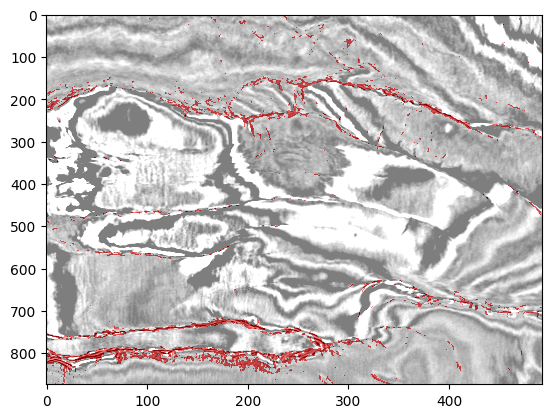

In [33]:
# plot two datasets together
vm = np.percentile(data, 95)
plt.imshow(data[:,:,104].T, cmap='gray', aspect='auto', vmin=-vm, vmax=vm)

vm = np.percentile(marfurt, 99)
plt.imshow(marfurt[:,:,4].T, cmap=cmap, aspect='auto', alpha = 0.5) # alpha controls transparency

plt.show()

Lastly, something commonly done in seismic interpretation is RGB blending. To achieve this every attribute is assigned either a Red, Blue, or Green colour and these layers and then stacked to produce a color image output that contains information of all 3 attributes. 

**EX 4: Repeat this exercise but with the TNW_small_2 datset we looked at in Exercise 3. Can you reveal any geological features better with attributes than you could with the original seismic volume in Exercise 3?**

### END OF SCRIPT